# Computational Design of Microbial Communities - part 4

Finally, we will use ABC SMC to compare multiple competing community designs.

In [1]:
import pyabc
import numpy as np
from scipy.integrate import solve_ivp
from typing import Callable, Union
from IPython.display import clear_output
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class GLVModel:
    """
    Generalized Lotka-Volterra model
    """
    def __init__(self, 
                 num_species: int, 
                 timepoints: np.ndarray, 
                 params: dict = None):
        self.timepoints = timepoints  # Time points for simulation
        self.num_species = num_species  # Number of species in the model
                
        # Set all parameters to 0 if none are provided
        if params is None:
            self.params = {
                "y0": np.zeros(self.num_species),
                "r": np.zeros(self.num_species),
                "A": np.zeros((self.num_species, self.num_species))
            }
        else:
            # if we have y0, r and A, assume we have been given full parameters
            if 'y0' in params.keys() and 'r' in params.keys() and 'A' in params.keys():
                self.params = params
            # otherwise, assume we have been given parameters in the form r_1, A_12 etc, that need reshaping 
            # (this allows us to pass in a subset of parameters to fix)
            else:
                self.params = {
                    'y0': np.zeros(self.num_species),
                    "r": np.zeros(self.num_species),
                    "A": np.zeros((self.num_species, self.num_species))
                }
                self.params = self._reshape_params(params)

    def _step(self, t, y, params):
        """
        Compute the derivatives for the gLV model.
        """ 
        r = params["r"]  # Growth rates (num species,)
        A = params["A"]  # Interaction matrix (num species, num species)
        # y  # Population values (num species,)

        dydt = (r + np.dot(A, y)) * y

        return dydt
    
    def simulate(self, params: dict) -> dict:
        """
        Simulate the model with the given parameters.
        """
        self.params = self._reshape_params(params)

        result = solve_ivp(self._step, 
                           t_span=[0, self.timepoints[-1]], 
                           y0=self.params["y0"], 
                           args=(self.params,), 
                           method='LSODA',  
                           t_eval=self.timepoints,
                           min_step=1e-3
                           )
        
        # Check if integration was successful
        if not result.success:
            return {"success": False}

        # Check for numerical issues
        if np.any(np.isnan(result.y)) or np.any(np.isinf(result.y)):
            return {"success": False}

        return {"success": True, "t": result.t, "y": result.y}

    def _reshape_params(self, params: dict) -> dict:
        """
        Incoming params dictionary has parameters with keys such as 'r_1', 'A_12' etc. This function reshapes them into vectors and matrices as appropriate.
        """
        reshaped_params = self.params.copy()
        for key in params.keys():
            if key.startswith('A_'):
                i, j = map(int, key[2:])
                reshaped_params['A'][i-1, j-1] = params[key]
            else:
                key_base, idx = key.rsplit('_', 1)
                idx = int(idx) - 1
                reshaped_params[key_base][idx] = params[key]

        return reshaped_params


In [3]:
def create_glv_priors(num_species: int = 2) -> dict:
    """
    Create a prior distribution for the gLV model parameters.
    num_species: number of species in the model
    Returns:
        dict: prior distribution for the model parameters
    """
    prior = {}
    for i in range(num_species):
        prior[f'y0_{i+1}'] = {'type': 'uniform', 'args': (0, 2)}  # note the uniform args in scipt.stats are loc and scale, equivalent to min and (max-min)
        prior[f'r_{i+1}'] = {'type': 'uniform', 'args': (-1, 2)}
        for j in range(num_species):
            prior[f'A_{i+1}{j+1}'] = {'type': 'uniform', 'args': (-1, 2)}

    return prior


In [4]:
def distance_function(simulated_data: dict, target_data: dict = None) -> float:
    """
    Compute the aggregated distance between simulated and an objective.
    simulated_data: dict with keys 'success', 't', 'y' from model.simulate()
    target_data: not used here, but could be used to compare to real data or target objectives
    Returns:
        float: distance metric
    """
    
    if simulated_data is None:
        raise ValueError("No simulated data provided")

    # If simulation failed or produced invalid data, return infinite distance
    if simulated_data['success'] is False:
        return np.inf    
    if np.any(simulated_data['y']) < 0:
        return np.inf
    

    distance = 0
    # for each species, calculate distance components
    for i in range(simulated_data['y'].shape[0]):
        # If a species goes extinct, return infinite distance
        final_population = simulated_data['y'][i, -1]
        if final_population <= 0:
            return np.inf
        elif target_data is not None:
            distance += (final_population - target_data['final_population'][i])**2 # squared difference to target final population
        
        # If the population is alive, check that it is stable i.e. minimise final gradient
        gradient = (simulated_data['y'][i, -1] - simulated_data['y'][i, -2]) / (simulated_data['t'][-1] - simulated_data['t'][-2])
        distance += abs(gradient)

    return distance

In [5]:
# Construct acceptor to reject particles with an infinite distance and use the default acceptor for the rest
class CustomAcceptor(pyabc.UniformAcceptor):
    def __init__(self):
        super().__init__()

    def __call__(self, distance_function, eps, x, x_0, t, par):
        d = distance_function(x, x_0, t, par)
        if np.isinf(d):
            return pyabc.acceptor.AcceptorResult(distance=1e9, accept=False)  # Reject particles with infinite distance
        # Otherwise, use the default acceptor logic
        return super().__call__(distance_function, eps, x, x_0, t, par)

We are going to create different variations of the gLV model by removing interactions between species. This is done by setting off-diagonal values in the interaction matrix $A$ to zero.

The number of possible communities that we can create this way is equal to the 2 raised to the power of the number of off-diagonal parameters (can you work out why?), which is given by $2^{n(n-1)}$, where $n$ is the number of species. You can probably see that this explodes rapidly as we increase the number of species: for 2 species we have 4 models, for 3 species we have 64, and for 4 species we have 4096.

If we assume that each species is interchangeable for the other then we can reduce this model space by removing symmetric models (e.g. the model with $A_{12}$ removed is the same as that with $A_{21}$ removed).

In [ ]:
# Create list of models
num_species = 2
num_off_diag = num_species * num_species - num_species
num_models = 2 ** num_off_diag
simulation_timepoints = np.linspace(0, 50, 51)
models = [GLVModel(num_species=num_species, timepoints=simulation_timepoints) for _ in range(num_models)]

# create list of prior distributions
priors = [{} for _ in range(num_models)]
for i in range(num_models):
    priors[i] = create_glv_priors(num_species=num_species)
# modify priors to create different model topologies
## create list of all species pairs where i != j
pairs_idx_list = [f'{i+1}{j+1}' for i in range(num_species) for j in range(num_species) if i != j]

## create list of all combinations of elements in pairs_idx_list, from 0 elements to all elements
from itertools import combinations
combinations_list = []
for r in range(len(pairs_idx_list) + 1):
    combinations_list.extend(combinations(pairs_idx_list, r))

# sort combinations_list by length of each combination (number of elements)
combinations_list = sorted(combinations_list, key=lambda x: len(x))

# now modify priors based on combinations_list
for i, combo in enumerate(combinations_list):
    # for each combination, delete the corresponding A_ij elements (this sets them to 0 and removes them from inference)
    for pair in combo:
        del priors[i][f'A_{pair}']
    priors[i] = pyabc.Distribution.from_dictionary_of_dictionaries( priors[i])  # convert to pyabc Distribution

In [24]:
# Setup ABC SMC
# pop_strategy = pyabc.populationstrategy.AdaptivePopulationSize(start_nr_particles=1000)
abc = pyabc.ABCSMC(models=[x.simulate for x in models], 
                   parameter_priors=priors, 
                   distance_function=distance_function, 
                   acceptor=CustomAcceptor(),
                #    population_size=1000,
                   population_size=num_models * 1000
                   )

db_path = "sqlite:///" + "250923_test_modelselection.db" # os.path.join(tempfile.gettempdir(), "test.db")

history = abc.new(db_path, observed_sum_stat={'final_population': [3.0, 5.0]})
history = abc.run(max_nr_populations=10)

ABC.History INFO: Start <ABCSMC id=5, start_time=2025-09-23 18:30:10>
ABC INFO: Calibration sample t = -1.
C:\Users\AJFed\AppData\Roaming\Python\Python312\site-packages\scipy\integrate\_ivp\lsoda.py:161: UserWarning: lsoda: Repeated error test failures (internal error).
  solver._y, solver.t = integrator.run(
C:\Users\AJFed\AppData\Roaming\Python\Python312\site-packages\scipy\integrate\_ivp\lsoda.py:161: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  solver._y, solver.t = integrator.run(
ABC INFO: t: 0, eps: inf.
C:\Users\AJFed\AppData\Roaming\Python\Python312\site-packages\scipy\integrate\_ivp\lsoda.py:161: UserWarning: lsoda: Repeated error test failures (internal error).
  solver._y, solver.t = integrator.run(
C:\Users\AJFed\AppData\Roaming\Python\Python312\site-packages\scipy\integrate\_ivp\lsoda.py:161: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  solver._y, solver.t = integrator.run(
ABC INFO:

<Axes: title={'center': 'Epsilon values'}, xlabel='Population index', ylabel='Epsilon'>

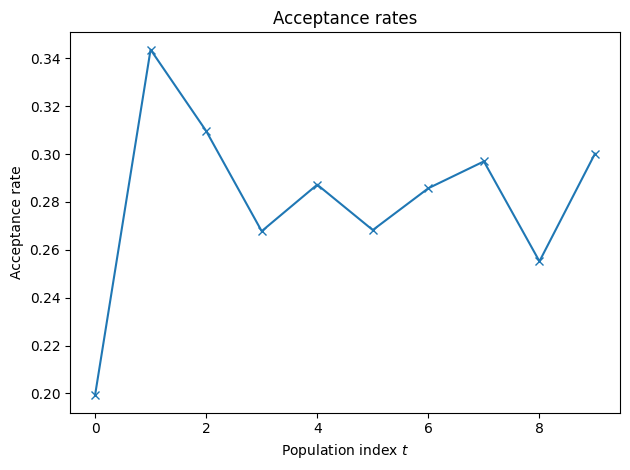

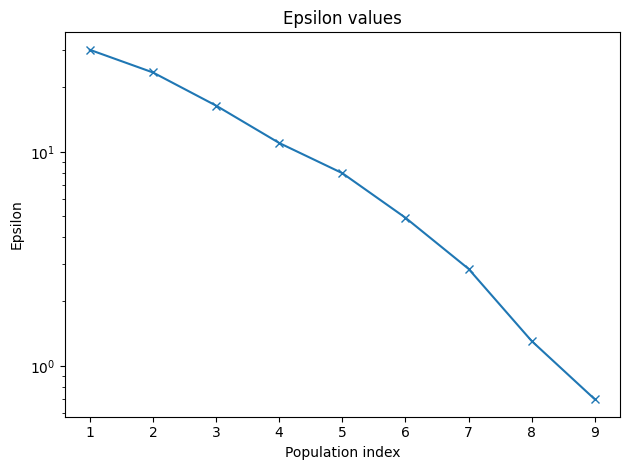

In [25]:
pyabc.visualization.plot_acceptance_rates_trajectory(history)
pyabc.visualization.plot_epsilons(history)

We can have a look at the model posterior probabilities to understand which models are better than others.

More formally we can use the Bayes factor (BF) which, if we use a uniform prior for model prior probabilities, is given by

$$BF = \frac{P(m_1|x)}{P(m_2|x)}$$

The BF is a measure of the support for $m_1$ relative to $m_2$. It accounts for the number of parameters, or complexity of the two models.

A Bayes factor >3 suggests $m_1$ is better than $m_2$. In the example below we can see that models 0 and 1 are better than model 3, but we don't have enough support to make any further claims.

Best model is model 1 with posterior probability 0.362


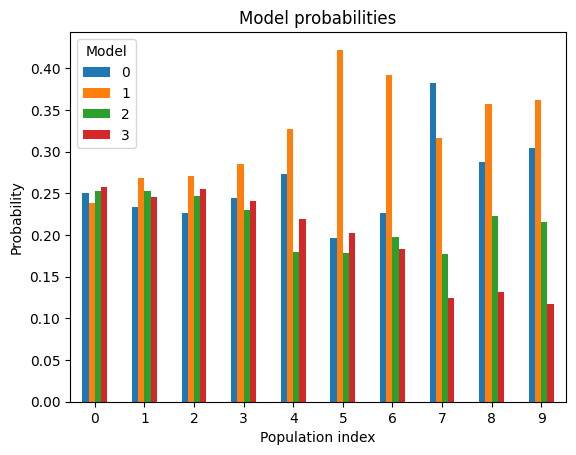

In [26]:
pyabc.visualization.plot_model_probabilities(history)

# get best model idx
model_probs = history.get_model_probabilities(t=history.max_t)
best_model_prob = max(model_probs['p'])
best_model_idx = model_probs[model_probs['p'] == best_model_prob].index[0]
print(f'Best model is model {best_model_idx} with posterior probability {best_model_prob:.3f}')

It can also be useful to visualise the networks. Here we visualise the highest probaility model and colour the edges based on whether the posterior mean interaction is positive or negative.

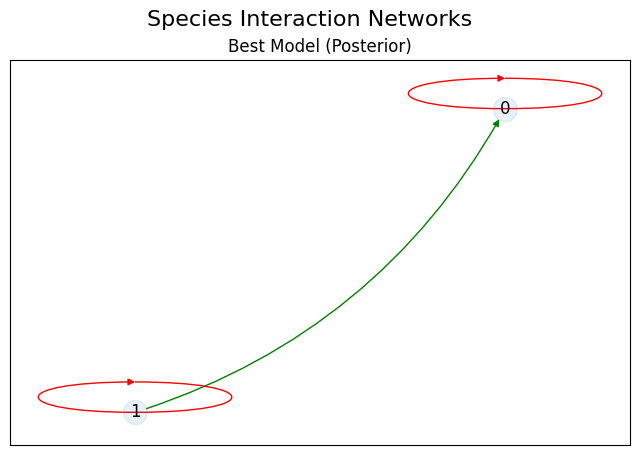

In [27]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import itertools as it

def plot_interaction_network_nx(ax, A, species_names=None, title="Species Interaction Network", 
                               pos_layout='circular', node_size=1000, font_size=12):
    """
    Plot a network diagram showing species interactions using NetworkX.
    
    Parameters:
    ax: matplotlib axis object
    A: interaction matrix (n x n numpy array)
    species_names: list of species names (optional)
    title: plot title
    pos_layout: layout type ('circular', 'spring', 'shell', etc.)
    node_size: size of nodes
    font_size: font size for labels
    """
    n_species = A.shape[0]
    
    if species_names is None:
        species_names = [i for i in range(n_species)]
    
    # Create directed graph
    # G = nx.DiGraph()
    G = nx.from_numpy_array(A, create_using=nx.DiGraph)

    # Add nodes
    # for i in range(n_species):
    #     G.add_node(i, label=species_names[i])

    # Add edges with weights
    edge_colors = []
    edge_widths = []
    edge_labels = {}
    
    for i in range(n_species):
        for j in range(n_species):
            if A[i, j] != 0:  # Skip zero interactions
                G.add_edge(i, j, weight=A[i, j])
                # Color based on interaction type
                if A[i, j] > 0:
                    edge_colors.append('green')
                else:
                    edge_colors.append('red')
                # Width proportional to absolute weight
                edge_widths.append(abs(A[i, j])*5)
                edge_labels[(i, j)] = f'{A[i, j]:.2f}'

    # Choose layout
    if pos_layout == 'circular':
        pos = nx.circular_layout(G)
    elif pos_layout == 'spring':
        pos = nx.spring_layout(G, k=0.5, iterations=50)
    elif pos_layout == 'shell':
        pos = nx.shell_layout(G)
    else:
        pos = nx.circular_layout(G)  # default
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, ax=ax, alpha=0.1)
    
    # Draw node labels
    nx.draw_networkx_labels(G, pos, ax=ax)
    # nx.draw_networkx_labels(G, pos, node_labels, font_size=font_size, 
    #                        font_weight='bold', ax=ax)
    
    # Draw edges    
    connectionstyle = [f"arc3,rad={r}" for r in it.accumulate([0.2] * 4)]
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, 
                        #    width=edge_widths, 
                          connectionstyle=connectionstyle, ax=ax)
    
    # Draw edge labels
    # nx.draw_networkx_edge_labels(G, pos, edge_labels, horizontalalignment='right', verticalalignment='top', ax=ax)
    
    ax.set_title(title, fontsize=12)
    # ax.axis('off')

fig, axes = plt.subplots(1, 1, figsize=(8, 5))
fig.suptitle('Species Interaction Networks', fontsize=16)

# get A matrix from model posteriors of best model
## make A matrix from posterior of best model
A2 = np.zeros((num_species, num_species))
best_model_params = history.get_distribution(m=best_model_idx, t=history.max_t)[0].median()
for param, value in best_model_params.items():
    if param.startswith('A_'):
        i, j = map(int, param[2:])
        A2[i-1, j-1] = value

plot_interaction_network_nx(axes, A2, title='Best Model (Posterior)', pos_layout='spring')


And we can see from the posterior parameter distributions that, for the highest probaility model, some of the parameters are very tightly constrained. 

array([[<Axes: ylabel='A_11'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='A_21'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='A_22'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='r_1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='r_2'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='y0_1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: xlabel='A_11', ylabel='y0_2'>, <Axes: xlabel='A_21'>,
        <Axes: xlabel='A_22'>, <Axes: xlabel='r_1'>,
        <Axes: xlabel='r_2'>, <Axes: xlabel='y0_1'>,
        <Axes: xlabel='y0_2'>]], dtype=object)

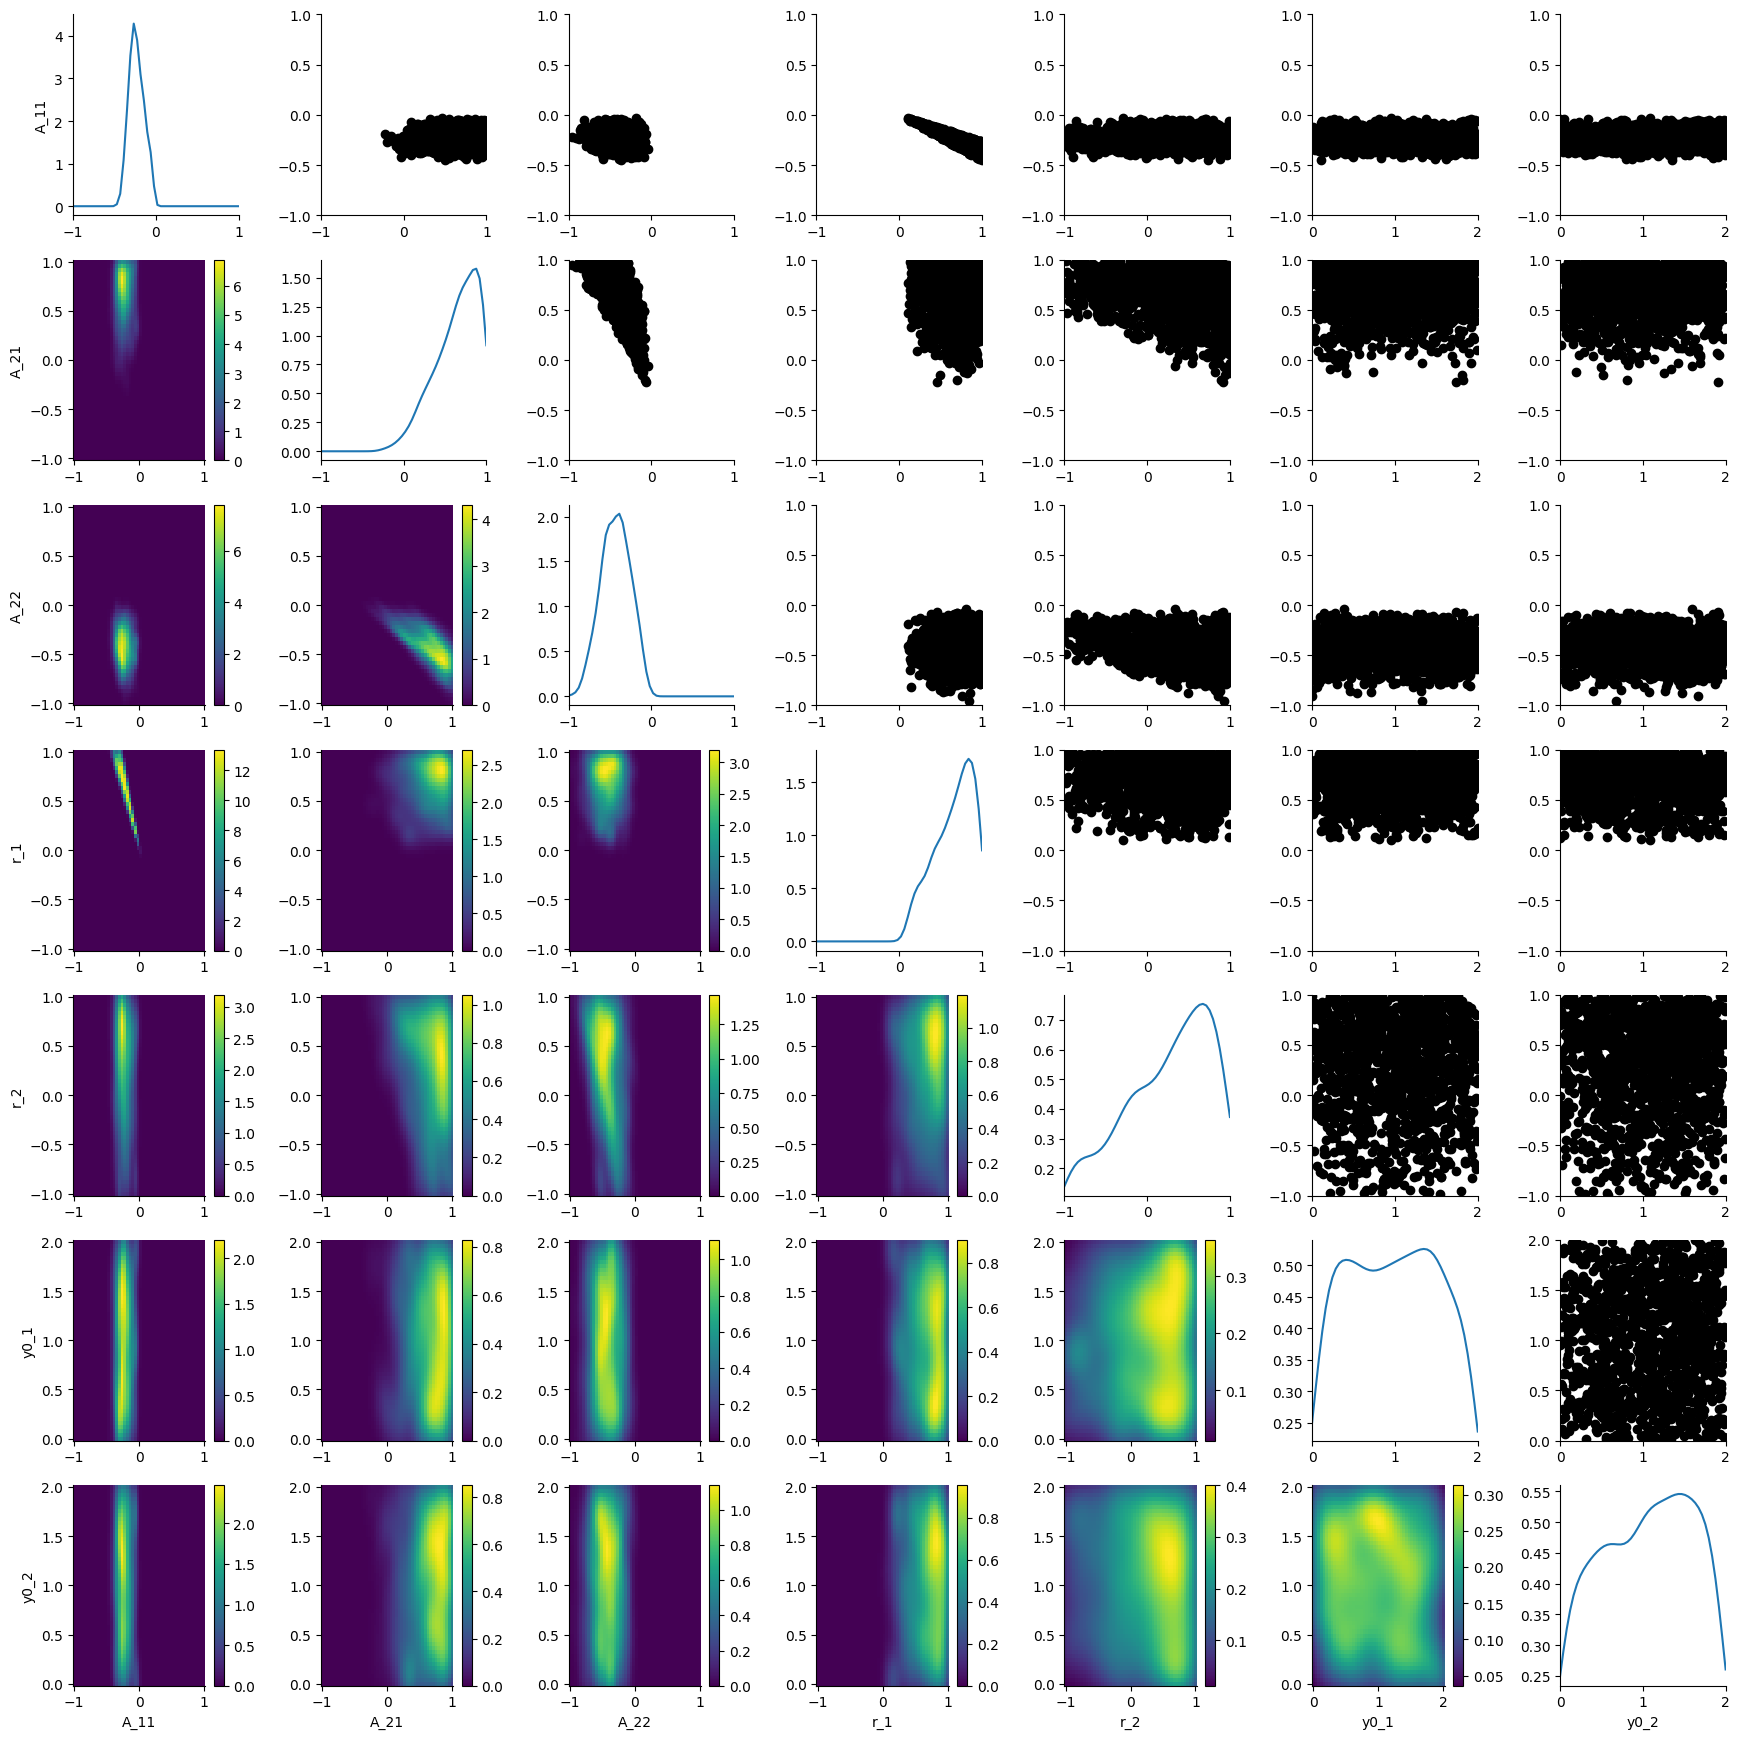

In [32]:
# get axes limits from best model priors for plotting
param_limits = {}
for key, dist in priors[best_model_idx].items():
    loc, scale = dist.args
    param_limits[key] = (loc, loc + scale)

pyabc.visualization.plot_kde_matrix_highlevel(history, m=best_model_idx, limits=param_limits)

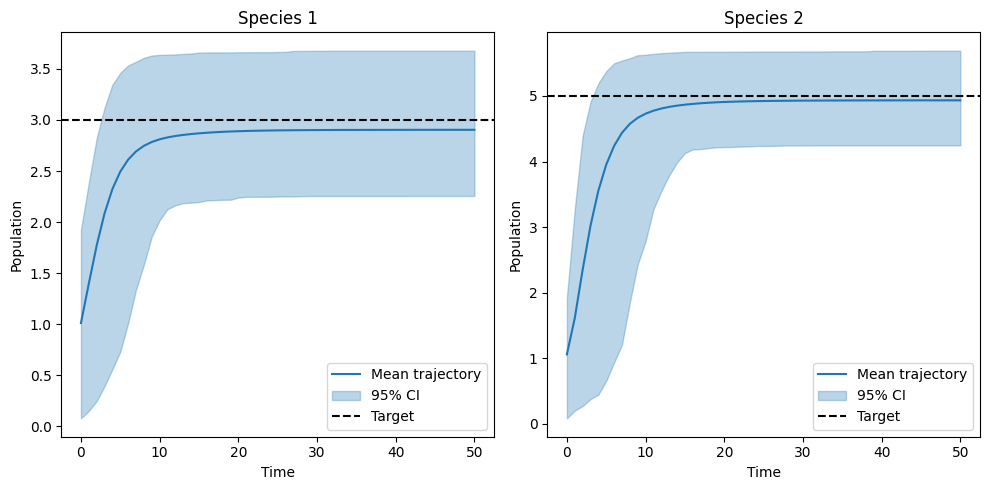

In [30]:
posteriors = history.get_population_extended(m=int(best_model_idx))

all_trajectories = []
for particle_idx in range(posteriors.shape[0]):
    all_trajectories.append(posteriors.iloc[particle_idx]["sumstat_y"])

all_trajectories = np.array(all_trajectories)  # shape: (N, 2, T)
n_species = all_trajectories.shape[1]
t = np.linspace(0, 50, 51)

fig, axes = plt.subplots(1, n_species, figsize=(10, 5), sharex=True)

for i in range(n_species):
    species_traj = all_trajectories[:, i, :]  # shape: (N, T)
    mean_traj = np.mean(species_traj, axis=0)
    lower = np.percentile(species_traj, 2.5, axis=0)
    upper = np.percentile(species_traj, 97.5, axis=0)

    ax = axes[i] if n_species > 1 else axes
    ax.plot(t, mean_traj, color='C0', label='Mean trajectory')
    ax.fill_between(t, lower, upper, color='C0', alpha=0.3, label='95% CI')
    ax.set_title(f"Species {i+1}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Population")

    # Add target line if desired
    if i == 0:
        ax.axhline(3.0, color='k', linestyle='--', label='Target')
    elif i == 1:
        ax.axhline(5.0, color='k', linestyle='--', label='Target')

    ax.legend()

plt.tight_layout()
plt.show()